# CS-6570 Lecture 15 - Dimension Reduction
**Dylan Zwick**

*Weber State University*

Most traditional statistical techniques for regression are intended for the _low-dimensional_ setting in which the number of observations $n$ is much greater than the number of features $p$. Throughout the field's history, the bulk of the problems involved a few predictors and a (relatively) large sample size.

This is no longer true. New technologies have transformed our capacity to collect, store, and process data in fields as diverse as finance, marketing, and medicine. For example:

* Rather than predicting blood pressure on the basis of, say, age, sex, and BMI, one might have measurements for half a million single nucleotide polymorphisms (SNPs; which are individual DNA mutations that are relatively common). Each of these SNPs could be a predictive variable in the model.


* A marketing analyst interested in understanding people's online shopping patterns could treat as features all of the search terms entered by users of a search engine. This is sometimes known as the "bag-of-words" model. The researcher might only have access to the search histories of a few hundred or a few thousand search engine users who have consented to share their information. For each user, each word is scored as a $0$ or $1$ and treated as a predictor for the model.

In both these cases, the number of predictors could be much higher than the number of observations.

It's madness to fit a standard regression model in this case, because you'll always get a perfect fit fit of your training data, and almost always do terribly on your testing data. Generally speaking, adding features that are truly associated with the response will improve the fitted model, but adding noise fetarues will deteriorate the model because of overfitting. This is called the _curse of dimensionality_, and is a key principle in the analysis of high dimensional data.

In both the situations above, we'd like to decrease the dimensionality of our data, but there's no real advantage to throwing out any of the predictors. The marginal cost of the additional predictors is almost nothing, and so getting the data for 100 predictors is not much easier than getting it for 10,000, and so if there were a way to still use all or most of the predictors while reducing dimensionality, that might be nice.

Mathematically, we can construct reduced dimensions as $Z_{1},Z_{2},\ldots,Z_{M}$, where $M < p$ and the $Z_{m}$ are linear combinations of our original $p$ predictors:

$\displaystyle Z_{m} = \sum_{j = 1}^{p}\phi_{jm}X_{j}$.


**Principle Component Analysis**

One way to do this is through Principle Component Analysis (PCA). PCA is a way to reduce the dimensionality, and hopefully increase the understanding, of (typically unlabeled) data, and so is usually considered a technique from unsupervised learning. However, it can also be a method for assisting regression analysis, as we'll see in this lecture. 

The basic idea behind principle component analysis is to find the dimension that does the best job of explaining the data, and then to find the dimension that does the second best job explaining the data after taking the first into account, and so on. The best job explaining the data here means the dimension that captures the greatest amount of the variance in the data. This can also be understood at the line that minimizes the distance between the line and the data points.

![PCA Chart](PCA%20Chart.png)

These are the two principle components for the two-dimensional distribution featured in the chart. Note the first principle component is along the direction in which the data varies the most, and the second principle component is perpendicular (a.k.a. orthogonal or normal) to it.

You can find a video that goes over the main ideas in PCA [here](https://youtu.be/HMOI_lkzW08). A more in-depth exploration can be found [here](https://youtu.be/FgakZw6K1QQ).

For the more mathematically inclined - the covariance matrix of any distribution is a positive semi-definite matrix, which means among other things that all its eigenvalues are real and non-negative, and that its corresponding eigenvectors are linearly independent. It turns out, the eigenvectors of the covariance matrix are exactly the principle components (the directions that maximize variance / the lines that minimize the distance to them), ordered by the size of the eigenvalues, and the relative sizes of the eigenvalues tell you the relative amount of the variance explained by each principle component. It's pretty cool! A video that goes over this a bit is [here](https://youtu.be/fkf4IBRSeEc).

**Principle Component Regression**

Suppose we take the first $M$ principle components. Each of our datapoints $\textbf{x}_{i}$ has a corresponding representation in terms of the principle components $\textbf{z}_{i} = (z_{i1},z_{i2},\ldots,z_{ip})$. We can fit a linear regression model on the first $M$ terms of this representation using our standard regression techniques:

$\displaystyle y_{i} = \theta_{0} + \sum_{m = 1}^{M}\theta_{m}z_{im} + \epsilon_{i}$, $i = 1,\ldots,n$.

This turns the problem of estimating $p+1$ coefficients $\beta_{0},\beta_{1},\ldots,\beta_{p}$, into the problem of estimating the $M+1$ coefficients $\theta_{0},\theta_{1},\ldots,\theta_{M}$, where $M < p$. 

Note:

$\displaystyle \sum_{m = 1}^{M}\theta_{m}z_{im} = \sum_{m = 1}^{M}\theta_{m}\sum_{j = 1}^{p}\phi_{jm}x_{ij} = \sum_{j = 1}^{p}\sum_{m = 1}^{M}\theta_{m}\phi_{jm}x_{ij} = \sum_{j = 1}^{p}\beta_{j}x_{ij}$,

where

$\displaystyle \beta_{j} = \sum_{m = 1}^{M}\theta_{m}\phi_{jm}$.

So this can be viewed as a special case of the linear regression model where the coefficient vector $\mathbf{\beta}$ is constrained to be a linear combination of the vectors $\mathbf{\phi}_{m}$. Note that if $M = p$ and the vectors $\mathbf{\phi}_{m}$ are linearly independent then this is no restriction at all.

***PCA In Python***

Let's take a look at this in the context of same data. Specifically, we'll use the Credit data from our discussion of ridge and lasso regression. But first, let's import our favorite libraries.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now, we can import the data:

We'll grab our standard predictor and target variables, and go through the transformations of the data we did before:

In [14]:
predictors = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married']
target = 'Balance'

credit_df['Own'] = credit_df['Own'].map({'No':0,'Yes':1})
credit_df['Student'] = credit_df['Student'].map({'No':0,'Yes':1})
credit_df['Married'] = credit_df['Married'].map({'No':0,'Yes':1})

X = credit_df[predictors]
y = credit_df[target]

We'll now generate our principle components. However, before we do so, we must take something about PCA into account. The choice of principle components is dependent on the *scale* of the predictors. So, before we do PCA, we'll want to scale our data so all our variables have zero mean and unit variance.

_Warning_: Risk of data leak! Do not use scale unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set. As we'll want to test our model on a test dataset, we'll want to split our data into a training set and a test set before we apply PCA.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we can scale our training and test data separately.

In [18]:
from sklearn.preprocessing import scale 
# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

With our data scaled appropriately, we can do PCA on the scaled training data.

In [20]:
from sklearn.decomposition import PCA
# Generate all the principal components
pca = PCA() # Default n_components = min(n_samples, n_features)
#The fit_transform returns a numpy array of each data point expressed in terms of the principle components
X_train_pc = pca.fit_transform(X_train_scaled)
# View the principle components
print(pca.components_)

[[ 5.44381070e-01  5.85388190e-01  5.85818790e-01  2.34217341e-02
   1.23048060e-01 -2.31057787e-02 -3.94698654e-02 -1.60170653e-03
   1.59612750e-03]
 [-5.72620799e-02 -4.18447246e-02 -1.79933328e-02  5.49447850e-01
   3.77865641e-01 -5.63472191e-01  1.45119033e-01 -1.52698719e-01
  -4.33697577e-01]
 [ 2.81772426e-02 -1.45805551e-02 -2.29035776e-02 -1.38737407e-01
   2.14363058e-01  3.13485823e-01  1.83776081e-01  6.84256382e-01
  -5.77074936e-01]
 [-1.77032570e-02  7.68327753e-02  8.25183604e-02  6.02776196e-02
  -5.05213740e-01 -2.88269826e-01  7.46294533e-01  2.46523928e-01
   1.65138292e-01]
 [-1.29095031e-02  1.55014812e-02  3.93900084e-02  5.15996213e-01
  -4.86813266e-01 -7.62675288e-02 -5.48290654e-01  4.33914429e-01
  -9.00659945e-03]
 [-3.90348841e-02 -2.20226321e-02  4.53589782e-03  6.03869825e-01
   3.18863467e-01  5.31657030e-01  2.57837524e-01  6.68553180e-02
   4.21934842e-01]
 [ 2.41805098e-02 -6.66257750e-02 -6.80844337e-02 -1.94647013e-01
   4.42926395e-01 -4.6053727

The pca class has an attribute "exploined_variance_ratio_" that returns the percentage of the variance that is explained by each principle component. Should be non-increasing.

In [22]:
i = 0
for c in pca.explained_variance_ratio_:
    i = i+1
    print("For component " + str(i) + " the percentage of the variance explained is: {:.2%}".format(c))

For component 1 the percentage of the variance explained is: 30.80%
For component 2 the percentage of the variance explained is: 13.03%
For component 3 the percentage of the variance explained is: 12.40%
For component 4 the percentage of the variance explained is: 11.36%
For component 5 the percentage of the variance explained is: 10.70%
For component 6 the percentage of the variance explained is: 10.10%
For component 7 the percentage of the variance explained is: 8.85%
For component 8 the percentage of the variance explained is: 2.73%
For component 9 the percentage of the variance explained is: 0.02%


***Principle Component Regression in Python***

Alright, so now we've got our principle components. But, we haven't yet answered an important question. How do we figure out the number of principle components to use? As usual, standard measures of fit like $RSS$ or $R^{2}$ aren't going to help, as they'll always increase with more components, until we're just back to standard regression. What we'll want to use is cross-validation.

Python has a function "cross_val_score" that's part of the model_selection library in sklearn. It calculates $k$ cross validation scores, where $k$ is the chosen number of folds. It inherently tries to maximize its score, and so does not have residiual sum of squares, but instead has the negative of the mean squared error. The mean squared error is just the residual sum of squares divided by the sample size, so... the mean of the squared error. Below, we use this, take the mean over all the folds, and then multiply by both the sample size (len(y)), and -1 to get the RSS. 

In [26]:
from sklearn.linear_model import LinearRegression
# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rss_list = []

from sklearn.model_selection import cross_val_score
# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rss_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=10, 
                                      scoring='neg_mean_squared_error').mean()*len(y_train)
    rss_list.append(rss_score)

We can plot the performance of the principle component regression model on the training data based on the number of principle components used:

[27066229.495065503, 27091090.928622954, 26211144.217201713, 23923041.25390045, 21505954.841507506, 21474224.75192905, 21590311.94332417, 3415113.08924641, 3402436.3372456348]


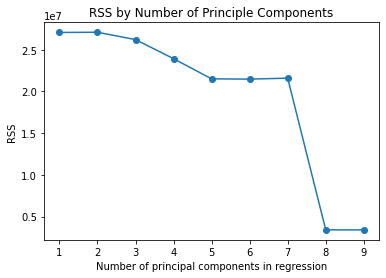

In [28]:
# Visual analysis - plot RSS vs count of principal components used
plt.xlabel('Number of principal components in regression')
plt.ylabel('RSS')
plt.title('RSS by Number of Principle Components')
#The next command just sets the xticks to start at 1 and not 0.
plt.xticks(np.arange(0,X_train_pc.shape[1]),np.arange(1, X_train_pc.shape[1]+1))
plt.plot(rss_list, '-o');

print(rss_list)

Alright, so it looks like we see a big drop when the number of principle components goes to 8. Now, let's check out how the models do on the test data.

[27138.151278373523, 26957.57183345366, 25944.615647220962, 25882.678493186933, 23764.71358057777, 23890.789944167354, 23912.149528559745, 11608.685998296409, 11612.739372434226]


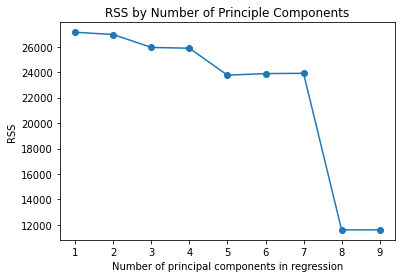

In [30]:
from sklearn.metrics import mean_squared_error

rss_test_list = []

for i in range(1, X_train_pc.shape[1]+1):
    lin_reg_pc = lin_reg.fit(X_train_pc[:,:i], y_train)
    X_test_pc = pca.transform(X_test_scaled)[:,:i]
    preds = lin_reg_pc.predict(X_test_pc)
    pcr_score_test = mean_squared_error(y_test,preds,squared=False)*len(y_test)
    rss_test_list.append(pcr_score_test)

plt.xlabel('Number of principal components in regression')
plt.ylabel('RSS')
plt.title('RSS by Number of Principle Components')
#The next command just sets the xticks to start at 1 and not 0.
plt.xticks(np.arange(0,X_test_pc.shape[1]),np.arange(1, X_test_pc.shape[1]+1))
plt.plot(rss_test_list, '-o');

print(rss_test_list)

It appears to do a bit better - a bit - with 8 principle components.